In [2]:
# Installing the necessary modeules
%pip install easyocr
%pip install imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 18.5 MB/s eta 0:00:00


In [4]:
#Importing modules
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import re

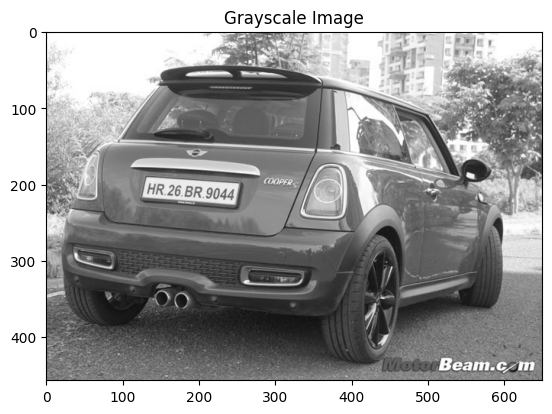

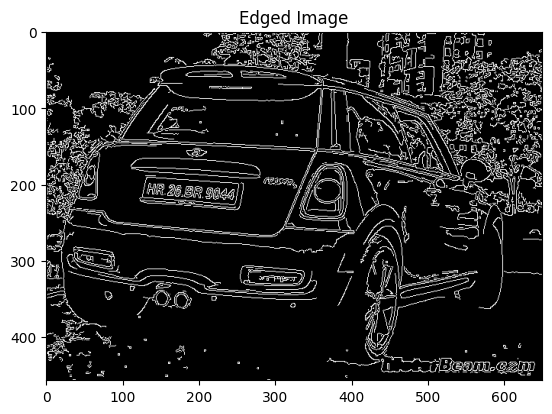

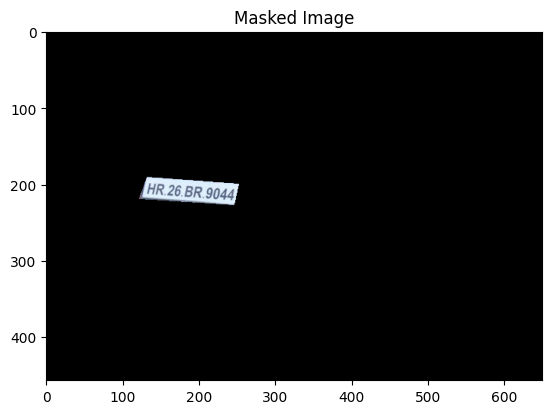

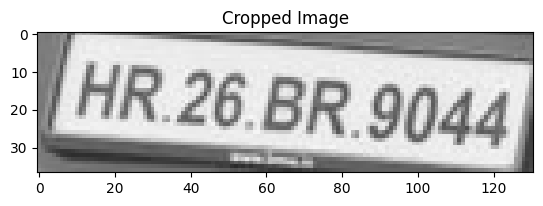

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma

Recognized License Plate Number: HR26BR9044


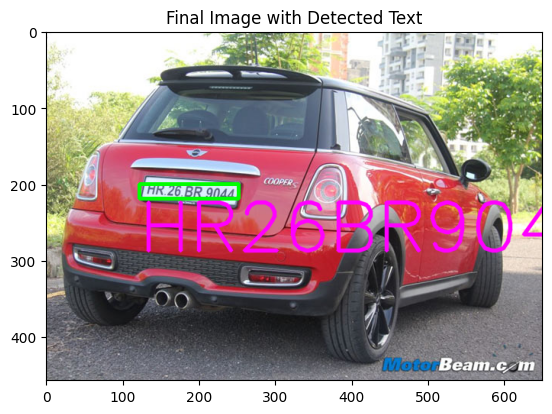

In [5]:
def load_image(image_path):
    """Load an image from the specified path."""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at the specified path: {image_path}")
    return img

def preprocess_image(img):
    """Convert image to grayscale and apply a bilateral filter."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filtered = cv2.bilateralFilter(gray, 11, 17, 17)  # Smoothens the image while preserving edges
    return gray, filtered

def detect_edges(filtered_img):
    """Detect edges in the image using the Canny edge detector."""
    return cv2.Canny(filtered_img, 50, 150)

def find_license_plate_contour(edged_img):
    """Find the contour that likely represents the license plate."""
    keypoints = cv2.findContours(edged_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:  # Looking for a quadrilateral
            return approx
    return None

def extract_license_plate(gray_img, img, location):
    """Extract and mask the license plate area from the image."""
    mask = np.zeros(gray_img.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0, 255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)

    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray_img[x1:x2+1, y1:y2+1]

    return new_image, cropped_image

def recognize_text(cropped_img):
    """Recognize text from the cropped license plate image using EasyOCR."""
    reader = easyocr.Reader(['en'])
    results = reader.readtext(cropped_img)

    if results:
        text = ''.join([res[1] for res in results])  # Concatenate all detected text
        return text
    return None

def clean_plate_text(text):
    """Clean the recognized license plate text."""
    # Use regex to remove unwanted characters and only retain alphanumeric values
    cleaned_text = re.sub(r'[^A-Za-z0-9]', '', text)
    return cleaned_text

def annotate_image(img, location, text):
    """Annotate the original image with the detected text and rectangle."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(location[0][0][0], location[1][0][1]+60),
                      fontFace=font, fontScale=3, color=(255, 0, 255), thickness=4, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)
    return res

def display_image(img, title='Image'):
    """Display an image with a title."""
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def main(image_path):
    # Load and preprocess the image
    img = load_image(image_path)
    gray, filtered = preprocess_image(img)

    # Display the grayscale image
    display_image(gray, 'Grayscale Image')

    # Detect edges and find the license plate contour
    edged = detect_edges(filtered)
    display_image(edged, 'Edged Image')

    location = find_license_plate_contour(edged)

    if location is not None:
        # Extract and display the license plate
        new_image, cropped_image = extract_license_plate(gray, img, location)
        display_image(new_image, 'Masked Image')
        display_image(cropped_image, 'Cropped Image')

        # Recognize text from the license plate
        raw_text = recognize_text(cropped_image)

        if raw_text:
            # Clean and print the recognized text
            clean_text = clean_plate_text(raw_text)
            print(f"Recognized License Plate Number: {clean_text}")

            # Annotate the original image with the recognized text
            final_img = annotate_image(img, location, clean_text)
            display_image(final_img, 'Final Image with Detected Text')
        else:
            print("No text detected.")
    else:
        print("No rectangular contour found.")

# Run the main function with the image path
main('/content/sample_data/Car_dataset/c2.jpg')


